# Comparing Machine Learning Techniques Using Pipelines - Lab

## Introduction

In this lab, you'lll use a Dataset created by Otto group, which was also used in a [Kaggle competition](https://www.kaggle.com/c/otto-group-product-classification-challenge/data).

The description of the data set is as follows:

The Otto Group is one of the world’s biggest e-commerce companies, with subsidiaries in more than 20 countries, including Crate & Barrel (USA), Otto.de (Germany) and 3 Suisses (France). They are selling millions of products worldwide every day, with several thousand products being added to our product line.

A consistent analysis of the performance of our products is crucial. However, due to their global infrastructure, many identical products get classified differently. Therefore, the quality of our product analysis depends heavily on the ability to accurately cluster similar products. The better the classification, the more insights Otto Group can generate about their product range.

In this lab, you'll use a data set containing:
- A column `id`, which is an anonymous id unique to a product
- 93 columns `feat_1`, `feat_2`, ..., `feat_93`, which are the various features of a product
- a column `target` - the class of a product


## Objectives

You will be able to:
- Compare different classification techniques
- Construct pipelines in scikit-learn
- Use pipelines in combination with GridSearchCV

## The Data Science Workflow

You will be following the data science workflow:

1. Initial data inspection, exploratory data analysis, and cleaning
2. Feature engineering and selection
3. create a baseline model
4. create a machine learning pipeline and compare results with the baseline model
5. Interpret the model and draw conclusions

##  Initial data inspection, exploratory data analysis, and cleaning

The data is stored in "otto_group.csv".

Things to do here:
- Check for NAs
- Check the distributions
- Check how many inputs there are
- ...

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('otto_group.csv')

In [3]:
data.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61878 entries, 0 to 61877
Data columns (total 95 columns):
id         61878 non-null int64
feat_1     61878 non-null int64
feat_2     61878 non-null int64
feat_3     61878 non-null int64
feat_4     61878 non-null int64
feat_5     61878 non-null int64
feat_6     61878 non-null int64
feat_7     61878 non-null int64
feat_8     61878 non-null int64
feat_9     61878 non-null int64
feat_10    61878 non-null int64
feat_11    61878 non-null int64
feat_12    61878 non-null int64
feat_13    61878 non-null int64
feat_14    61878 non-null int64
feat_15    61878 non-null int64
feat_16    61878 non-null int64
feat_17    61878 non-null int64
feat_18    61878 non-null int64
feat_19    61878 non-null int64
feat_20    61878 non-null int64
feat_21    61878 non-null int64
feat_22    61878 non-null int64
feat_23    61878 non-null int64
feat_24    61878 non-null int64
feat_25    61878 non-null int64
feat_26    61878 non-null int64
feat_27    61878 non-null i

In [36]:
data.isna().sum().sum()

0

In [37]:
feat = data.drop(['id','target'], axis=1)

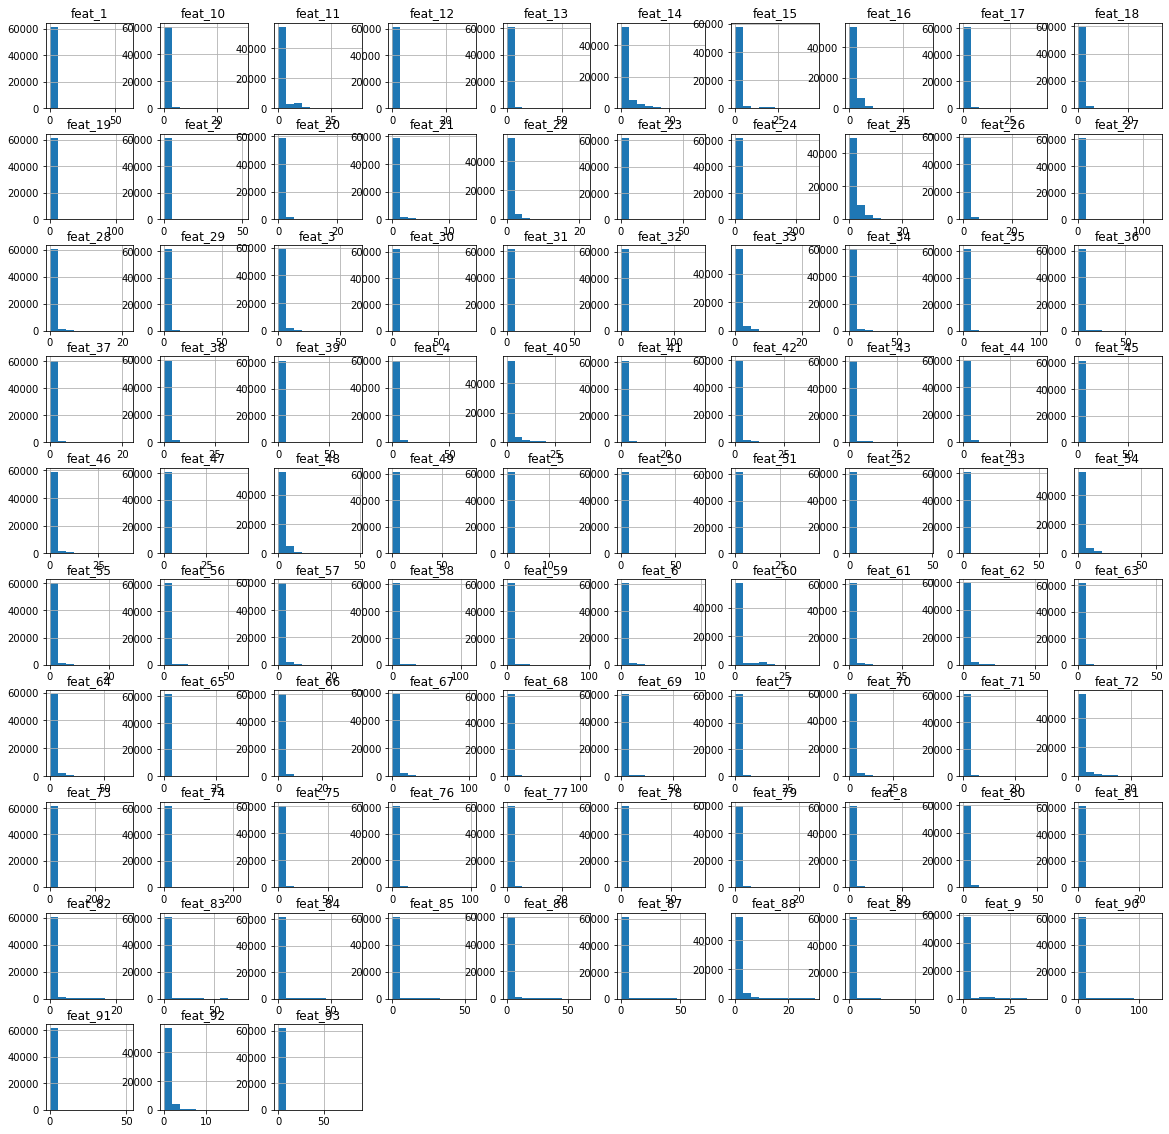

In [38]:
feat.hist(figsize=(20,20));

If you look at all the histograms, you can tell that a lot of the data are zero-inflated, so most of the variables contain mostly zeros and then some higher values here and there. No normality, but for most machine learning techniques this is not an issue. 

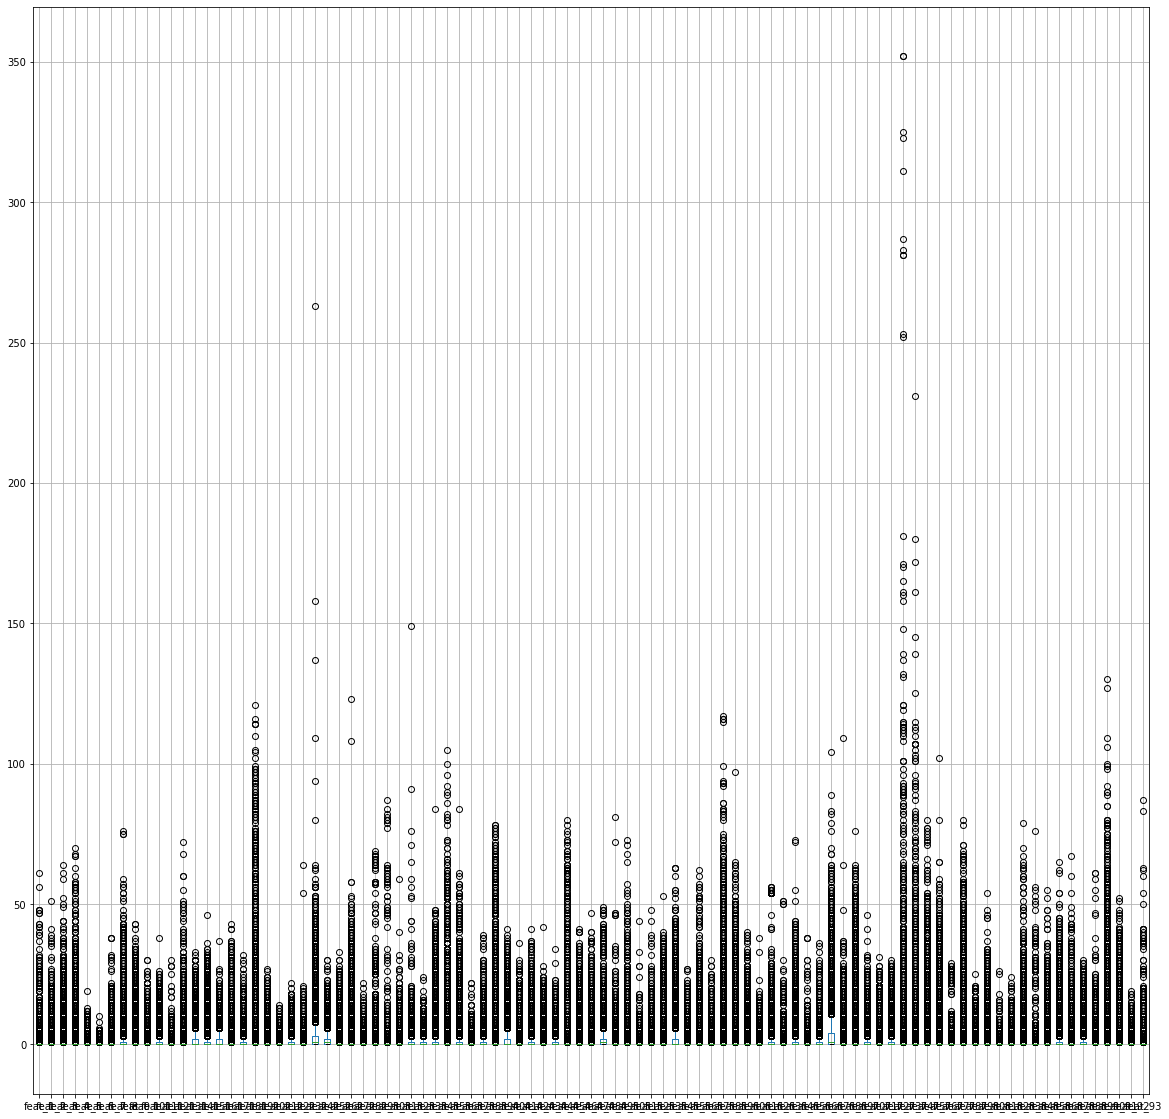

In [39]:
feat.boxplot(figsize=(20,20))

Because the data is zero-inflated the boxplots look as shown above. Because there are this many zeroes, most values above zero will seem to be outliers. The safe decision for this data is to not delete any outliers and see what happens. With many 0s, sparse data is available and high values may be super informative. More-over, without having any intuitive meaning for each of the features, we don't know if a value of ~260 is actually an outlier.

## Feature engineering and selection with PCA

Have a look at the correlation structure of your features using a heatmap.

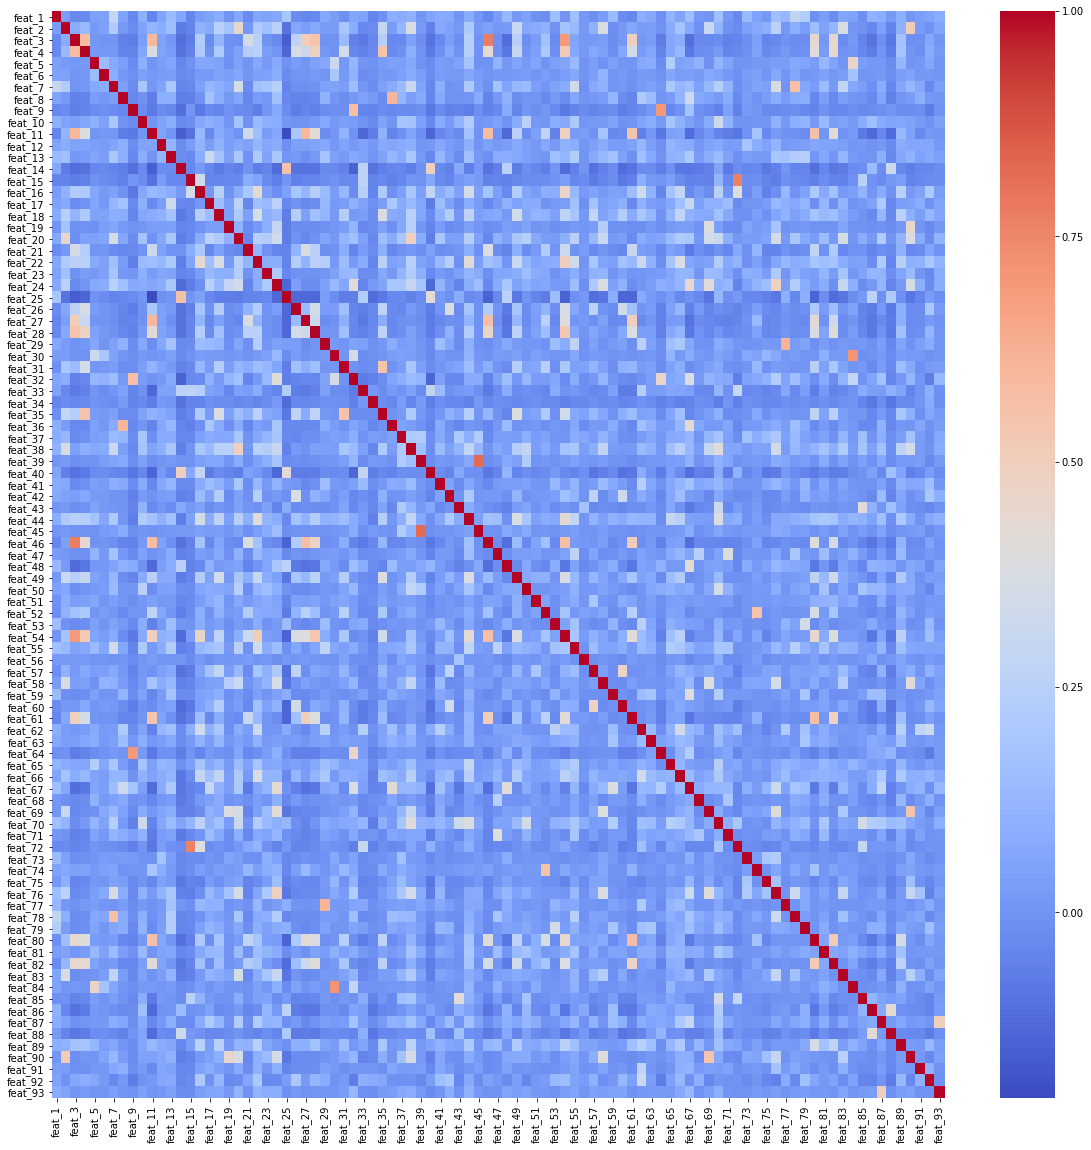

In [42]:
plt.figure(figsize=(20,20))
sns.heatmap(feat.corr(), cmap='coolwarm')

Use PCA to downscale your features. Use PCA to select a number of features in a way that you still keep 80% of your explained variance.

In [43]:
pca = PCA(n_components=27)
pca.fit_transform(feat)

array([[ 0.68354922, -1.4565603 ,  1.41190569, ..., -0.1092096 ,
         1.2602436 , -0.74941028],
       [-2.64598874, -1.89324807, -0.27687385, ..., -0.46172607,
        -0.05697916, -0.18203928],
       [-1.88129707, -3.11141972,  0.16706523, ...,  0.63563643,
         0.66532528, -0.14187027],
       ...,
       [ 4.24144948, -7.46680534,  6.8096946 , ..., -4.36873781,
        -4.71593833, -0.84823061],
       [-0.34705223, -2.21289626,  1.3892883 , ..., -0.18836891,
         1.62517783, -0.50428769],
       [ 1.50228549, -0.68171479,  3.49456495, ...,  0.86337613,
         0.12499854,  0.98865422]])

In [44]:
pca.explained_variance_ratio_.cumsum()

array([0.11772072, 0.20386621, 0.26774827, 0.32903525, 0.37312763,
       0.41282704, 0.44771842, 0.47921905, 0.50859906, 0.53606066,
       0.56199304, 0.58424404, 0.60586216, 0.62556717, 0.6447921 ,
       0.66339847, 0.68091652, 0.69796823, 0.71346659, 0.72760165,
       0.74003618, 0.75184721, 0.7625356 , 0.77268706, 0.78266541,
       0.79192919, 0.80041634])

## Create a train test split with a test size of 40%

This is a relatively big training set. Feel free to make it smaller (down to ~20%), but for an initial run you can try smaller training sets so the computation time is more manageable.

For now, simply use the original data and not the principal components. We looked at the PC's first to get a sense of our correlation structure, and to see how we can downsize our data without losing too much information. In what's next, you'll make PCA part of the pipeline!!

In [5]:
y = data['target']
X = data.drop(['id','target'], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

## Create a baseline model

Create your baseline model *in a pipeline setting*. In the pipeline
- Your first step will be to scale your features down to the number of features that ensure you keep just 80% of your explained variance (which we saw before)
- Your second step will be the building a basic logistic regression model.

Make sure to fit the model using the training set, and test the result by obtaining the accuracy using the test set.

In [45]:
pipe = Pipeline([('pca', PCA(n_components=27)),
                ('logistic', LogisticRegression(random_state=42))])

In [46]:
pipe.fit(X_train, y_train)

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=27, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [47]:
y_preds = pipe.predict(X_test)

In [48]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

     Class_1       0.39      0.06      0.10       795
     Class_2       0.58      0.91      0.71      6456
     Class_3       0.48      0.20      0.29      3141
     Class_4       0.85      0.05      0.10      1070
     Class_5       0.95      0.94      0.94      1085
     Class_6       0.90      0.91      0.91      5694
     Class_7       0.74      0.40      0.52      1107
     Class_8       0.79      0.86      0.83      3370
     Class_9       0.78      0.78      0.78      2034

   micro avg       0.72      0.72      0.72     24752
   macro avg       0.72      0.57      0.57     24752
weighted avg       0.72      0.72      0.68     24752



In [49]:
accuracy_score(y_test, y_preds)

0.7176389786683904

In [50]:
y_train_preds = pipe.predict(X_train)
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

     Class_1       0.48      0.06      0.11      1134
     Class_2       0.58      0.92      0.71      9666
     Class_3       0.51      0.21      0.30      4863
     Class_4       0.81      0.06      0.11      1621
     Class_5       0.95      0.94      0.94      1654
     Class_6       0.90      0.91      0.91      8441
     Class_7       0.76      0.42      0.54      1732
     Class_8       0.81      0.86      0.83      5094
     Class_9       0.78      0.79      0.78      2921

   micro avg       0.72      0.72      0.72     37126
   macro avg       0.73      0.57      0.58     37126
weighted avg       0.72      0.72      0.68     37126



In [51]:
accuracy_score(y_train, y_train_preds)

0.7193072240478371

## Create a pipeline consisting of a linear SVM, a simple Decision Tree and a simple Random Forest Classifier

Repeat the above, but now create three different pipelines:
- One for a standard linear SCM
- One for a default decision tree
- One for a RandomForestClassifier

In [52]:
pipe = Pipeline([('pca', PCA(n_components=27)),
                ('clf', svm.SVC(random_state=42, kernel='linear'))])
pipe.fit(X_train, y_train)
y_preds = pipe.predict(X_test)
print('Test Scores')
print(classification_report(y_test, y_preds))
print(accuracy_score(y_test, y_preds))
y_train_preds = pipe.predict(X_train)
print('\nTrain Score')
print(classification_report(y_train, y_train_preds))
print(accuracy_score(y_train, y_train_preds))

Test Scores
              precision    recall  f1-score   support

     Class_1       0.45      0.19      0.26       795
     Class_2       0.61      0.94      0.74      6456
     Class_3       0.58      0.12      0.20      3141
     Class_4       0.73      0.15      0.25      1070
     Class_5       0.96      0.94      0.95      1085
     Class_6       0.90      0.92      0.91      5694
     Class_7       0.69      0.50      0.58      1107
     Class_8       0.78      0.89      0.83      3370
     Class_9       0.79      0.80      0.80      2034

   micro avg       0.73      0.73      0.73     24752
   macro avg       0.72      0.61      0.61     24752
weighted avg       0.73      0.73      0.69     24752

0.7346881060116355

Train Score
              precision    recall  f1-score   support

     Class_1       0.48      0.18      0.26      1134
     Class_2       0.60      0.94      0.73      9666
     Class_3       0.59      0.12      0.20      4863
     Class_4       0.72      0.17 

In [53]:
pipe = Pipeline([('pca', PCA(n_components=27)),
                ('decision', DecisionTreeClassifier(random_state=42))])
pipe.fit(X_train, y_train)
y_preds = pipe.predict(X_test)
print('Test Scores')
print(classification_report(y_test, y_preds))
print(f'Test accuracy: {accuracy_score(y_test, y_preds)}')
y_train_preds = pipe.predict(X_train)
print('\nTrain Score')
print(classification_report(y_train, y_train_preds))
print(f'Train accuracy: {accuracy_score(y_train, y_train_preds)}')

Test Scores
              precision    recall  f1-score   support

     Class_1       0.28      0.29      0.29       795
     Class_2       0.67      0.65      0.66      6456
     Class_3       0.41      0.43      0.42      3141
     Class_4       0.26      0.27      0.26      1070
     Class_5       0.91      0.90      0.91      1085
     Class_6       0.88      0.87      0.88      5694
     Class_7       0.45      0.44      0.44      1107
     Class_8       0.77      0.78      0.77      3370
     Class_9       0.72      0.72      0.72      2034

   micro avg       0.67      0.67      0.67     24752
   macro avg       0.59      0.59      0.59     24752
weighted avg       0.67      0.67      0.67     24752

Test accuracy: 0.6689964447317388

Train Score
              precision    recall  f1-score   support

     Class_1       0.94      0.95      0.94      1134
     Class_2       0.98      0.98      0.98      9666
     Class_3       0.96      0.96      0.96      4863
     Class_4       

In [54]:
pipe = Pipeline([('pca', PCA(n_components=27)),
                ('forest', RandomForestClassifier(random_state=42, n_jobs=-1))])
pipe.fit(X_train, y_train)
y_preds = pipe.predict(X_test)
print('Test Scores')
print(classification_report(y_test, y_preds))
print(f'Test accuracy: {accuracy_score(y_test, y_preds)}')
y_train_preds = pipe.predict(X_train)
print('\nTrain Score')
print(classification_report(y_train, y_train_preds))
print(f'Train accuracy: {accuracy_score(y_train, y_train_preds)}')

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test Scores
              precision    recall  f1-score   support

     Class_1       0.48      0.35      0.41       795
     Class_2       0.67      0.83      0.74      6456
     Class_3       0.49      0.40      0.44      3141
     Class_4       0.52      0.20      0.29      1070
     Class_5       0.97      0.94      0.95      1085
     Class_6       0.91      0.92      0.92      5694
     Class_7       0.65      0.49      0.56      1107
     Class_8       0.82      0.87      0.85      3370
     Class_9       0.81      0.81      0.81      2034

   micro avg       0.75      0.75      0.75     24752
   macro avg       0.70      0.65      0.66     24752
weighted avg       0.73      0.75      0.73     24752

Test accuracy: 0.7460811247575954

Train Score
              precision    recall  f1-score   support

     Class_1       0.99      0.95      0.97      1134
     Class_2       0.96      1.00      0.98      9666
     Class_3       0.98      0.95      0.96      4863
     Class_4       

## Pipeline with grid search

Construct 3 pipelines with grid search
- one for support vector machines - make sure your grid isn't too big. You'll see it takes quite a while to fit SVMs with non-linear kernel functions!
- one for random forests - try to have around 40 different models
- one for the adaboost algorithm. 

### SVM pipeline with grid search

In [10]:
# Create the pipeline
pipe_svm = Pipeline([('pca', PCA(n_components=10)),
                ('clf', svm.SVC(random_state=42))])

pipe_rf = Pipeline([('pca', PCA(n_components=27)),
                ('clf', RandomForestClassifier(random_state=42))])

pipe_ada = Pipeline([('pca', PCA(n_components=27)),
                ('clf', AdaBoostClassifier(random_state=42))])

pipes = [pipe_svm, pipe_rf, pipe_ada]

In [55]:
# Create the grid parameter
grid_svm = [{'clf__C': [0.01, 1, 100],
         'clf__degree': [2,3,4,5],
         'clf__gamma': [0.001, 0.01]}]

In [56]:
# Create the grid, with "pipe" as the estimator
gridsearch_svm = GridSearchCV(estimator=pipe_svm,
                  param_grid=grid_svm,
                  scoring='accuracy',
                  cv=3, verbose=1, n_jobs=-1)
# Fit using grid search
gridsearch_svm.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 15.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__C': [0.01, 1, 100], 'clf__degree': [2, 3, 4, 5], 'clf__gamma': [0.001, 0.01]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

Use your grid search object along with `.cv_results` to get the full result overview

In [57]:
df_svm = pd.DataFrame(gridsearch_svm.cv_results_)
df_svm.head()

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\l

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__degree,param_clf__gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,90.104529,0.326523,19.726613,0.077500,0.01,2,0.001,"{'clf__C': 0.01, 'clf__degree': 2, 'clf__gamma...",0.539667,0.544242,0.545058,0.542989,0.002373,24,0.543195,0.541675,0.543974,0.542948,0.000955
1,82.501514,2.463677,20.143832,2.148056,0.01,2,0.01,"{'clf__C': 0.01, 'clf__degree': 2, 'clf__gamma...",0.624010,0.617455,0.616908,0.619458,0.003227,19,0.623081,0.617874,0.619602,0.620185,0.002165
2,94.164012,2.158022,21.178734,2.435550,0.01,3,0.001,"{'clf__C': 0.01, 'clf__degree': 3, 'clf__gamma...",0.541121,0.544081,0.544492,0.543231,0.001502,23,0.543397,0.541756,0.544096,0.543083,0.000981
3,84.252169,3.103874,17.946371,0.728885,0.01,3,0.01,"{'clf__C': 0.01, 'clf__degree': 3, 'clf__gamma...",0.624333,0.618182,0.617150,0.619889,0.003171,17,0.622838,0.618157,0.619682,0.620226,0.001949
4,91.447272,2.349004,18.236928,0.589112,0.01,4,0.001,"{'clf__C': 0.01, 'clf__degree': 4, 'clf__gamma...",0.541121,0.544242,0.545785,0.543716,0.001940,21,0.543882,0.542039,0.544176,0.543366,0.000946


In [58]:
df_svm.sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__degree,param_clf__gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
19,56.455456,1.762101,10.812437,0.246204,100,3,0.01,"{'clf__C': 100, 'clf__degree': 3, 'clf__gamma'...",0.711908,0.706263,0.707266,0.708479,0.002459,1,0.765072,0.762030,0.760393,0.762498,0.001939
23,51.149631,2.821766,7.177153,1.007112,100,5,0.01,"{'clf__C': 100, 'clf__degree': 5, 'clf__gamma'...",0.712716,0.705455,0.707185,0.708452,0.003097,2,0.765557,0.761343,0.760756,0.762552,0.002138
17,55.911908,2.377533,10.896213,0.121059,100,2,0.01,"{'clf__C': 100, 'clf__degree': 2, 'clf__gamma'...",0.711585,0.704323,0.708559,0.708156,0.002978,3,0.765153,0.762595,0.762211,0.763320,0.001306
21,56.390960,0.611365,10.792491,0.099604,100,4,0.01,"{'clf__C': 100, 'clf__degree': 4, 'clf__gamma'...",0.711585,0.704242,0.708155,0.707994,0.003000,4,0.764951,0.760575,0.761322,0.762283,0.001911
9,38.766729,0.452115,11.967351,0.081693,1,2,0.01,"{'clf__C': 1, 'clf__degree': 2, 'clf__gamma': ...",0.706011,0.696485,0.694254,0.698917,0.005099,5,0.708906,0.704174,0.708157,0.707079,0.002077


In [59]:
df_svm['Train_test_diff'] = df_svm['mean_train_score'] - df_svm['mean_test_score']

In [60]:
df_svm.loc[df_svm['mean_test_score'] > .66].sort_values(by=['Train_test_diff'], ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__degree,param_clf__gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,Train_test_diff
10,36.915676,0.865399,12.456045,0.426880,1,3,0.001,"{'clf__C': 1, 'clf__degree': 3, 'clf__gamma': ...",0.677977,0.676444,0.672189,0.675537,0.002448,13,0.680055,0.671407,0.677413,0.676292,0.003618,0.000754
14,37.984486,0.263715,12.078719,0.545163,1,5,0.001,"{'clf__C': 1, 'clf__degree': 5, 'clf__gamma': ...",0.676765,0.677010,0.671462,0.675079,0.002559,14,0.679489,0.672013,0.677332,0.676278,0.003142,0.001199
12,39.329889,0.415716,12.170143,0.351152,1,4,0.001,"{'clf__C': 1, 'clf__degree': 4, 'clf__gamma': ...",0.676927,0.676283,0.671381,0.674864,0.002476,16,0.679489,0.671407,0.677534,0.676144,0.003443,0.001280
8,39.237471,1.460074,11.798136,0.277567,1,2,0.001,"{'clf__C': 1, 'clf__degree': 2, 'clf__gamma': ...",0.677735,0.676283,0.671220,0.675079,0.002793,14,0.680297,0.671771,0.677009,0.676359,0.003511,0.001280
20,42.187254,2.947255,10.839364,0.055435,100,4,0.001,"{'clf__C': 100, 'clf__degree': 4, 'clf__gamma'...",0.702294,0.696646,0.693688,0.697544,0.003570,9,0.706683,0.701871,0.706096,0.704883,0.002144,0.007340


In [61]:
# Best accuracy
print('Best accuracy: %.3f' % gridsearch_svm.best_score_)

# Best params
print('\nBest params:\n', gridsearch_svm.best_params_)

Best accuracy: 0.708

Best params:
 {'clf__C': 100, 'clf__degree': 3, 'clf__gamma': 0.01}


### Random Forest pipeline with grid search

In [12]:
# Create the grid parameter
grid_rf = [{'clf__criterion': ['gini', 'entropy'],
         'clf__max_depth': [3,4,5],
         'clf__min_samples_leaf': [8,10,12],
         'clf__min_impurity_decrease': [.001, .01, .1],
         'clf__min_samples_split': [10,15,20,25]}]

In [13]:
# Create the grid, with "pipe" as the estimator
gridsearch_rf = GridSearchCV(estimator=pipe_rf,
                  param_grid=grid_rf,
                  scoring='accuracy',
                  cv=3, verbose=1, n_jobs=-1)
# Fit using grid search
gridsearch_rf.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  6.4min finished
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=27, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
           ...rs='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__criterion': ['gini', 'entropy'], 'clf__max_depth': [3, 4, 5], 'clf__min_samples_leaf': [8, 10, 12], 'clf__min_impurity_decrease': [0.001, 0.01, 0.1], 'clf__min_samples_split': [10, 15, 20, 25]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [34]:
# Best accuracy
print('Best accuracy: %.3f' % gridsearch_rf.best_score_)

# Best params
print('\nBest params:\n', gridsearch_rf.best_params_)

Best accuracy: 0.659

Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_impurity_decrease': 0.001, 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 10}


In [31]:
df_rf = pd.DataFrame(gridsearch_rf.cv_results_)

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\l

In [66]:
df_rf.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_depth,param_clf__min_impurity_decrease,param_clf__min_samples_leaf,param_clf__min_samples_split,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.013876,0.399773,0.111789,0.042813,gini,3,0.001,8,10,"{'clf__criterion': 'gini', 'clf__max_depth': 3...",...,0.591192,0.620545,0.601842,0.013265,104,0.596614,0.596703,0.620288,0.604535,0.011139
1,3.447838,0.078391,0.138915,0.006646,gini,3,0.001,8,15,"{'clf__criterion': 'gini', 'clf__max_depth': 3...",...,0.592485,0.620626,0.602570,0.012795,100,0.597139,0.598077,0.621864,0.605693,0.011441
2,3.276090,0.162781,0.140352,0.055525,gini,3,0.001,8,20,"{'clf__criterion': 'gini', 'clf__max_depth': 3...",...,0.592970,0.621191,0.603028,0.012867,98,0.597462,0.597754,0.621945,0.605720,0.011473
3,2.794672,0.410238,0.095826,0.014262,gini,3,0.001,8,25,"{'clf__criterion': 'gini', 'clf__max_depth': 3...",...,0.592808,0.617554,0.601519,0.011351,106,0.597180,0.597673,0.619157,0.604670,0.010246
4,2.528286,0.069013,0.138923,0.030468,gini,3,0.001,10,10,"{'clf__criterion': 'gini', 'clf__max_depth': 3...",...,0.592485,0.622242,0.602920,0.013676,99,0.597058,0.597511,0.622510,0.605693,0.011893


In [33]:
df_rf.sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_depth,param_clf__min_impurity_decrease,param_clf__min_samples_leaf,param_clf__min_samples_split,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
180,6.939153,0.449412,0.090113,0.013548,entropy,5,0.001,8,10,"{'clf__criterion': 'entropy', 'clf__max_depth'...",...,0.659152,0.655459,0.659107,0.002959,1,0.666761,0.662357,0.658425,0.662514,0.003405
184,7.218640,0.166696,0.091724,0.009204,entropy,5,0.001,10,10,"{'clf__criterion': 'entropy', 'clf__max_depth'...",...,0.658343,0.658611,0.658730,0.000373,2,0.662720,0.662599,0.660607,0.661976,0.000969
188,6.686402,0.581164,0.092169,0.020375,entropy,5,0.001,12,10,"{'clf__criterion': 'entropy', 'clf__max_depth'...",...,0.657051,0.659420,0.658110,0.000983,3,0.662155,0.662155,0.660890,0.661733,0.000596
190,6.001352,0.295316,0.110085,0.022608,entropy,5,0.001,12,20,"{'clf__criterion': 'entropy', 'clf__max_depth'...",...,0.655030,0.657722,0.657895,0.002412,4,0.664539,0.660135,0.660243,0.661639,0.002051
182,6.882354,0.986886,0.082823,0.004918,entropy,5,0.001,8,20,"{'clf__criterion': 'entropy', 'clf__max_depth'...",...,0.651798,0.657561,0.657895,0.005119,4,0.666721,0.659691,0.660122,0.662178,0.003217


## Adaboost

In [62]:
# Set grid search params
adaboost_param_grid = {
    'clf__n_estimators': [30, 50, 70],
    'clf__learning_rate': [1.0, 0.5, 0.1]
}

# Construct grid search
gridsearch_ada = GridSearchCV(estimator=pipe_ada,
            param_grid=adaboost_param_grid,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gridsearch_ada.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] clf__learning_rate=1.0, clf__n_estimators=30 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=30, total=   3.7s
[CV] clf__learning_rate=1.0, clf__n_estimators=30 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] ..... clf__learning_rate=1.0, clf__n_estimators=30, total=   3.6s
[CV] clf__learning_rate=1.0, clf__n_estimators=30 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=30, total=   3.7s
[CV] clf__learning_rate=1.0, clf__n_estimators=50 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=50, total=   6.0s
[CV] clf__learning_rate=1.0, clf__n_estimators=50 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=50, total=   5.9s
[CV] clf__learning_rate=1.0, clf__n_estimators=50 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=50, total=   6.0s
[CV] clf__learning_rate=1.0, clf__n_estimators=70 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=70, total=   8.4s
[CV] clf__learning_rate=1.0, clf__n_estimators=70 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=70, total=   8.3s
[CV] clf__learning_rate=1.0, clf__n_estimators=70 ....................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=27, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'clf__n_estimators': [30, 50, 70], 'clf__learning_rate': [1.0, 0.5, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [63]:
df_ada = pd.DataFrame(gridsearch_ada.cv_results_)
df_ada.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.684819,0.034839,0.085838,0.003272,1,30,"{'clf__learning_rate': 1.0, 'clf__n_estimators...",0.656487,0.598141,0.620545,0.625061,0.024034,5,0.662397,0.604864,0.623884,0.630382,0.023933
1,5.953422,0.033221,0.123028,0.000956,1,50,"{'clf__learning_rate': 1.0, 'clf__n_estimators...",0.623283,0.621495,0.610523,0.618435,0.005641,6,0.625788,0.627207,0.614592,0.622529,0.005642
2,8.233995,0.094091,0.165580,0.002789,1,70,"{'clf__learning_rate': 1.0, 'clf__n_estimators...",0.582485,0.592404,0.615776,0.596886,0.013956,8,0.581825,0.598844,0.617945,0.599538,0.014754
3,3.616336,0.052894,0.081462,0.002340,0.5,30,"{'clf__learning_rate': 0.5, 'clf__n_estimators...",0.643480,0.657455,0.652712,0.651215,0.005803,3,0.650517,0.656499,0.659476,0.655497,0.003725
4,5.802157,0.036553,0.122339,0.003847,0.5,50,"{'clf__learning_rate': 0.5, 'clf__n_estimators...",0.653175,0.669495,0.665805,0.662824,0.006988,1,0.663326,0.669993,0.668000,0.667106,0.002794


In [64]:
df_ada.sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
4,5.802157,0.036553,0.122339,0.003847,0.5,50,"{'clf__learning_rate': 0.5, 'clf__n_estimators...",0.653175,0.669495,0.665805,0.662824,0.006988,1,0.663326,0.669993,0.668000,0.667106,0.002794
5,8.064776,0.009443,0.161953,0.001232,0.5,70,"{'clf__learning_rate': 0.5, 'clf__n_estimators...",0.647277,0.670869,0.662410,0.660184,0.009759,2,0.655568,0.672458,0.667192,0.665073,0.007056
3,3.616336,0.052894,0.081462,0.002340,0.5,30,"{'clf__learning_rate': 0.5, 'clf__n_estimators...",0.643480,0.657455,0.652712,0.651215,0.005803,3,0.650517,0.656499,0.659476,0.655497,0.003725
8,8.010259,0.020798,0.161592,0.001392,0.1,70,"{'clf__learning_rate': 0.1, 'clf__n_estimators...",0.624253,0.623758,0.629273,0.625761,0.002492,4,0.628778,0.625672,0.626793,0.627081,0.001284
0,3.684819,0.034839,0.085838,0.003272,1,30,"{'clf__learning_rate': 1.0, 'clf__n_estimators...",0.656487,0.598141,0.620545,0.625061,0.024034,5,0.662397,0.604864,0.623884,0.630382,0.023933


In [65]:
# Best accuracy
print('Best accuracy: %.3f' % gridsearch_ada.best_score_)

# Best params
print('\nBest params:\n', gridsearch_ada.best_params_)

Best accuracy: 0.663

Best params:
 {'clf__learning_rate': 0.5, 'clf__n_estimators': 50}


## Note

Note that this solution is only one of many options. The results in the Random Forest and Adaboost models show that there is a lot of improvement possible tuning the hyperparameters further, so make sure to explore this yourself!

## Summary 

Great! You now got a lot of practice in. What algorithm would you choose and why?